# FWI in time domain

In [5]:
import numpy as np
from jax import jit, vjp, vmap, pmap
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field
from hybridoed.oed import *

from functools import partial

import numpy as np
from jax import grad, jit, lax, nn
from jax import numpy as jnp
from jax import random, value_and_grad, vmap
from jax.example_libraries import optimizers
from matplotlib import pyplot as plt
from tqdm import tqdm

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (
    Domain,
    Medium,
    Sensors,
    Sources,
    TimeAxis,
    circ_mask,
    points_on_circle,
)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth

(500, 1, 70, 70)


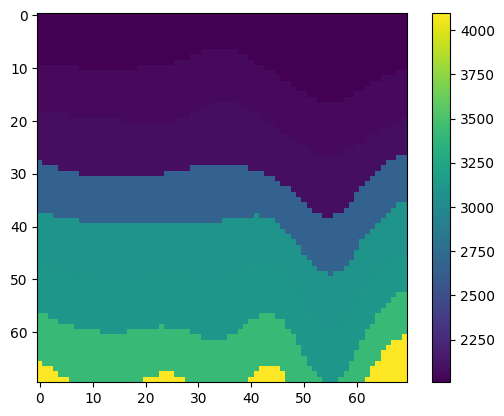

<class 'jaxlib.xla_extension.ArrayImpl'>


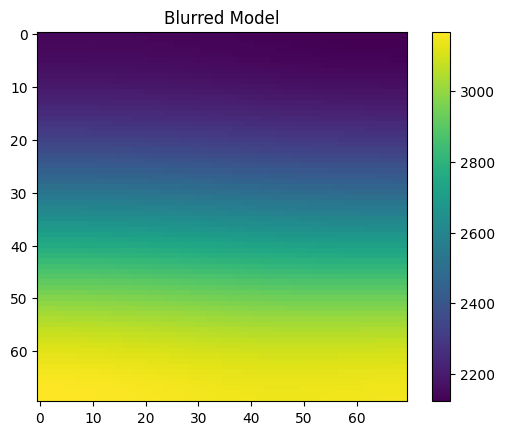

(70, 70)


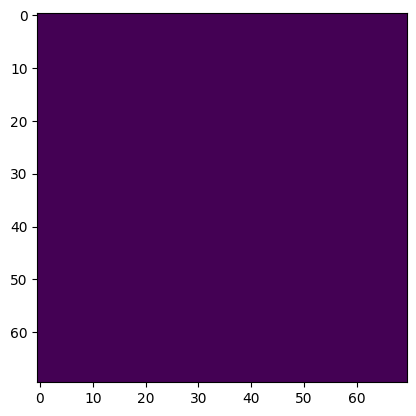

In [210]:
model = jnp.load('model1.npy')
print(model.shape)

true_model = model[7,0,:,:]
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=20)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap='viridis')
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)

# homogenous model of the velocity avegare

homogenous_model = jnp.ones(true_model.shape) * jnp.mean(true_model)

plt.imshow(homogenous_model)



In [209]:
N = (70, 70)  # Grid size
dx = (1.0, 1.0)  # Spatial resolution
cfl=0.25

# Defining the domain
domain = Domain(N, dx)

source_freq = 200
source_mag = 1.3e-1
# source_mag = 1.3

medium = Medium(domain=domain, sound_speed=true_model, density=1000., pml_size=10)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)
t = time_axis.to_array()
source_mag = source_mag / time_axis.dt

s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t + 100)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 0.5e-2, 1e-2)

# generate a ricker signal instead of a sinusoidal signal

def ricker_wavelet(t, f, t_shift=0.0):
    """
    Generate a Ricker wavelet with a time shift.

    Parameters:
        t (array-like): Time axis (e.g., jax.numpy array).
        f (float): Central frequency of the wavelet.
        t_shift (float): Time shift for the wavelet (default is 0.0).

    Returns:
        jax.numpy.ndarray: Ricker wavelet values at the given time points.
    """
    t_shifted = t - t_shift  # Apply the time shift
    pi2 = (jnp.pi ** 2)
    a = (pi2 * f ** 2) * (t_shifted ** 2)
    wavelet = (1 - 2 * a) * jnp.exp(-a)
    return wavelet


# Parameters
# source_freq = 25.0  # Central frequency in Hz
# t = jnp.linspace(-0.1, 0.2, 1000)  # Time vector in seconds
t_shift = 0.005  # Time shift in seconds

# Generate the Ricker wavelet with time shift
signal = source_mag * ricker_wavelet(t, source_freq, t_shift)

# Plot the Ricker wavelet
# plt.plot(t, ricker_signal)
# plt.title("Ricker Wavelet with Time Shift")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.axvline(x=t_shift, color="red", linestyle="--", label="Shift Start")
# plt.grid()
# plt.legend()
# plt.show()



# src_coords_list = jnp.array([
#     [60.1, 16.1],
#     [60.1, 24.1],
#     [60.1, 32.1],
#     [60.1, 40.1],
#     [60.1, 48.1],
# ]  ).astype(jnp.int32)

# receiver_coords_list = jnp.array([
#     [8.1, 0.125 * N[1] + 0.1],
#     [8.1, 0.25 * N[1] + 0.1],
#     [8.1, 0.5 * N[1] + 0.1],
#     [8.1, 0.75 * N[1] + 0.1],
#     [8.1, 0.9 * N[1] + 0.1],
# ]).astype(jnp.int32)
def generate_positions(num_sources, num_receivers, spacing=None):
    src_coords = []
    recv_coords = []

    if spacing is None:
        # automatically compute the spacing
        spacing_source = N[0] // (num_sources + 1)
        spacing_receiver = N[0] // (num_receivers + 1)
    else:
        spacing_source = spacing
        spacing_receiver = spacing
    
    # src_spacing = (N[1] - 2 * spacing_source) // (num_sources - 1)
    # recv_spacing = (N[1] - 2 * spacing_receiver) // (num_receivers - 1)
    
    for i in range(num_sources):
        src_coords.append([8, spacing_source + i * spacing_source])
    
    for i in range(num_receivers):
        recv_coords.append([8, spacing_receiver + i * spacing_receiver])
    
    return jnp.array(src_coords).astype(jnp.int32), jnp.array(recv_coords).astype(jnp.int32)

def generate_edge_positions(N=(70, 70), num_points=10, margin=5):
    """
    Generate line positions for sources and receivers on all four edges of the domain.
    
    Parameters
    ----------
    N : tuple of int
        Domain size, e.g., (Nx, Ny).
    num_points : int
        Number of points placed on each edge.
    margin : int or float
        Distance from the corner to start placing points.
    
    Returns
    -------
    src_coords : jnp.ndarray
        Coordinates of sources at the four edges of the domain.
    recv_coords : jnp.ndarray
        Coordinates of receivers at the four edges of the domain.
    """
    Nx, Ny = N

    # Top line (near y=margin)
    x_top = jnp.linspace(margin, Nx - margin, num_points)
    y_top = jnp.ones(num_points) * margin
    top_line = jnp.stack([x_top, y_top], axis=-1)

    # Bottom line (near y=Ny - margin)
    x_bottom = jnp.linspace(margin, Nx - margin, num_points)
    y_bottom = jnp.ones(num_points) * (Ny - margin)
    bottom_line = jnp.stack([x_bottom, y_bottom], axis=-1)

    # Left line (near x=margin)
    y_left = jnp.linspace(margin, Ny - margin, num_points)
    x_left = jnp.ones(num_points) * margin
    left_line = jnp.stack([x_left, y_left], axis=-1)

    # Right line (near x=Nx - margin)
    y_right = jnp.linspace(margin, Ny - margin, num_points)
    x_right = jnp.ones(num_points) * (Nx - margin)
    right_line = jnp.stack([x_right, y_right], axis=-1)

    # Combine all lines
    all_positions = jnp.concatenate([top_line, bottom_line, left_line, right_line], axis=0)

    # Here we are assigning the same positions to sources and receivers.
    # If you want different sets, you can adjust the code.
    src_coords = all_positions + 1
    recv_coords = all_positions

    return src_coords.astype(jnp.int32), recv_coords.astype(jnp.int32)

def generate_random_src_rec_position(N=(70, 70), num_sources=5, num_receivers=69):
    """
    Generate random positions for sources and receivers.
    
    Parameters
    ----------
    N : tuple of int
        Domain size, e.g., (Nx, Ny).
    num_sources : int
        Number of sources.
    num_receivers : int
        Number of receivers.
    
    Returns
    -------
    src_coords : jnp.ndarray
        Random coordinates of sources.
    recv_coords : jnp.ndarray
        Random coordinates of receivers.
    """
    Nx, Ny = N

    # Randomly select positions for sources and receivers
    src_coords = random.randint(key, (num_sources, 2), 0, Nx, dtype=jnp.int32)
    recv_coords = random.randint(key, (num_receivers, 2), 0, Nx, dtype=jnp.int32)

    return src_coords, recv_coords

def generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=20, num_receivers=10):
    """
    Generate a 2D grid of positions for sources and receivers with more sources than receivers,
    arranged in a staggered grid. The offset between a source and a receiver is half the source spacing.

    Parameters:
    - N: Tuple[int, int], dimensions of the 2D grid (Nx, Ny).
    - num_sources: int, number of source positions along each axis.
    - num_receivers: int, number of receiver positions along each axis.

    Returns:
    - src_coords: jnp.ndarray, source positions as a 2D array.
    - recv_coords: jnp.ndarray, receiver positions as a 2D array.
    """
    Nx, Ny = N

    # Generate evenly spaced indices for sources
    src_x = jnp.linspace(5, Nx - 5, num_sources, dtype=jnp.float32)
    src_y = jnp.linspace(5, Ny - 5, num_sources, dtype=jnp.float32)

    # Compute receiver positions with fewer points
    recv_x = jnp.linspace(5 + (src_x[1] - src_x[0]) / 2, Nx - 5 - (src_x[1] - src_x[0]) / 2, num_receivers, dtype=jnp.float32)
    recv_y = jnp.linspace(5 + (src_y[1] - src_y[0]) / 2, Ny - 5 - (src_y[1] - src_y[0]) / 2, num_receivers, dtype=jnp.float32)

    # Create 2D grid coordinates for sources and receivers
    src_coords = jnp.array([[x, y] for x in src_x for y in src_y], dtype=jnp.int32)
    recv_coords = jnp.array([[x, y] for x in recv_x for y in recv_y], dtype=jnp.int32)

    return src_coords, recv_coords

    

# src_coords_list, receiver_coords_list = generate_positions(num_sources=5, num_receivers=69)

# src_coords_list, receiver_coords_list = generate_edge_positions(N=(70, 70), num_points=20, margin=10)

# src_coords_list, receiver_coords_list = generate_random_src_rec_position(N=(70, 70), num_sources=5, num_receivers=69)

src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)


num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

print(sensors_positions)

(Array([12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 46, 46,
       46, 46, 46, 57, 57, 57, 57, 57], dtype=int32), Array([12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23,
       35, 46, 57, 12, 23, 35, 46, 57], dtype=int32))


Text(0.5, 1.0, 'Source signals')

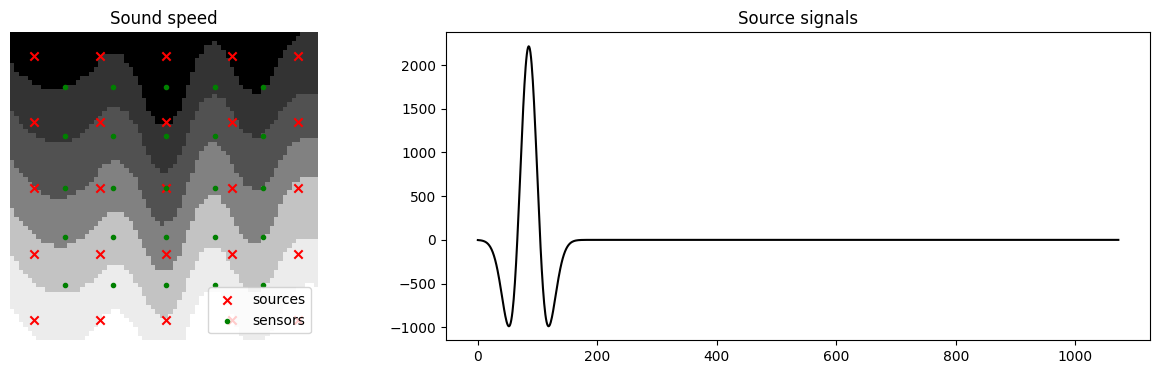

In [192]:

 # Show simulation setup
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

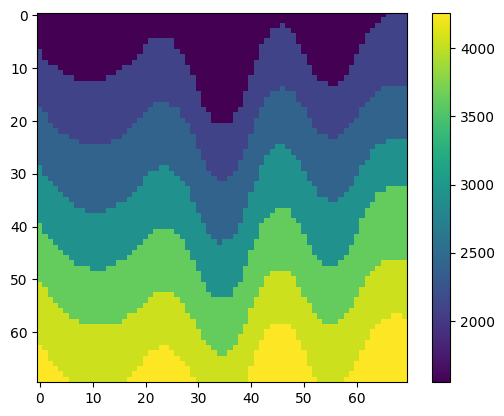

In [193]:
plt.imshow(medium.sound_speed.on_grid)
plt.colorbar()

In [194]:
src_signal = jnp.stack([signal])

# We can compile the entire function! All the constructors
# that don't depend on the inputs will be statically compiled
# and run only once.
@jit
def single_source_simulation(sound_speed, source_num):
    # Setting source
    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    sources = Sources((x, y), src_signal, dt=time_axis.dt, domain=domain)

    # Updating medium with the input speed of sound map
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=10)

    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[..., 0]

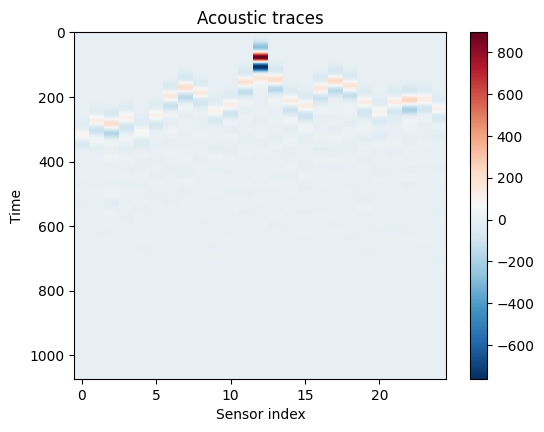

In [195]:
p = single_source_simulation(medium.sound_speed, num_sources // 2)

# Visualize the acoustic traces
plt.figure(figsize=(6, 4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(
    p, cmap="RdBu_r", interpolation="nearest", aspect="auto"
)
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()

In [196]:
# %%timeit
# single_source_simulation(medium.sound_speed, 1).block_until_ready()

In [197]:
batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

Size of data [Source idx, Time, Sensor idx]: (25, 1073, 25)


In [198]:
# %%timeit
# batch_simulations(medium.sound_speed, jnp.arange(num_sources)).block_until_ready()

In [199]:
# p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
# noise = np.random.normal(size=p_data.shape) * 0.2
# noise = jnp.fft.fft(noise, axis=1)
# #noise = noise.at[:, 100:-100].set(0.0)
# noise = jnp.fft.ifft(noise, axis=1).real
# p_data = p_data + noise

# plt.plot(p_data[1, :, 0])
# plt.title("Example of noisy traces")
# plt.show()

In [200]:
from jaxdf.operators import compose

# mask = circ_mask(domain.N, 80, (128, 128))
# mask = FourierSeries(jnp.expand_dims(mask, -1), domain)

# mask the pixel of the source and receviers defined above
mask = jnp.ones(domain.N)

mask = mask.at[sensors_positions[0], sensors_positions[1]].set(0.0)




def get_sound_speed(params):
    return params + compose(params)(nn.sigmoid) * mask

# initial model is the blurred model
params = blurred_model
# params = homogenous_model
# params = medium.sound_speed * 0.1 + 
params

array([[2025.499 , 2025.5305, 2025.594 , ..., 2166.0056, 2166.594 ,
        2166.889 ],
       [2027.0304, 2027.0619, 2027.1251, ..., 2167.6213, 2168.2102,
        2168.5054],
       [2030.0902, 2030.1216, 2030.1847, ..., 2170.8496, 2171.4392,
        2171.7346],
       ...,
       [3632.22  , 3632.216 , 3632.2085, ..., 3763.503 , 3764.0767,
        3764.3643],
       [3635.7988, 3635.7947, 3635.787 , ..., 3766.7944, 3767.367 ,
        3767.654 ],
       [3637.5908, 3637.5864, 3637.5789, ..., 3768.4421, 3769.0142,
        3769.301 ]], dtype=float32)

In [201]:
from jwave.signal_processing import analytic_signal
from jaxdf.operators import gradient, functional

def hilbert_transf(signal, noise=0.2):
    x = jnp.abs(analytic_signal(signal))
    return x

def loss_func(params, source_num):
    c0 = get_sound_speed(params)
    p = single_source_simulation(c0, source_num)
    data = p_data[source_num]
    # return jnp.mean(jnp.abs(hilbert_transf(p) -hilbert_transf(data)) ** 2)
    # L2 loss
    return jnp.mean((p - data) ** 2)

loss_with_grad = value_and_grad(loss_func, argnums=0)

def loss_func_multi(params, source_nums):
    """
    Compute the loss for multiple sources by averaging their individual losses.
    """
    c0 = get_sound_speed(params)
    total_loss = 0.0
    for src_num in source_nums:
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        total_loss += jnp.mean((p - data) ** 2)  # L2 loss
    return total_loss / len(source_nums)  # Average loss over sources

loss_with_grad_multi = value_and_grad(loss_func_multi, argnums=0)

In [202]:
p_data.shape

(25, 1073, 25)

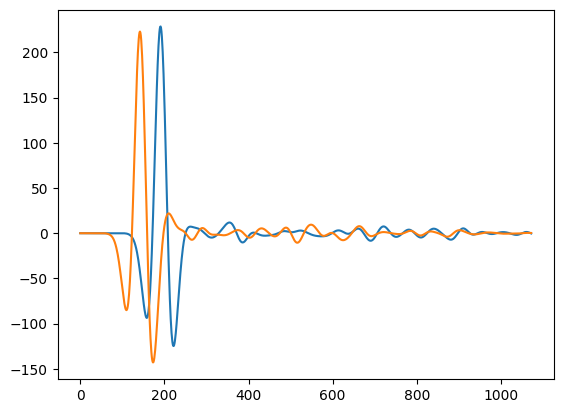

In [203]:
# plt.plot(hilbert_transf(p_data[0, :, 0]))
plt.plot(p_data[0, :, 0])
plt.plot(p_data[1, :, 1])
plt.show()

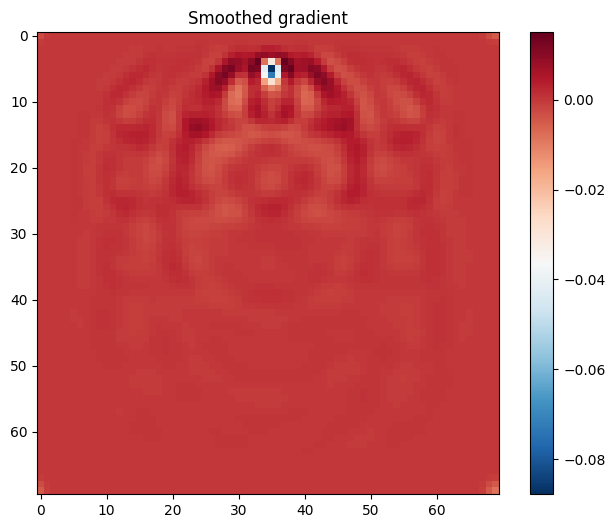

In [204]:
def smooth_fun(gradient):
    # x = gradient.on_grid[..., 0]
    x = gradient
    for _ in range(1):
        x = smooth(x)
    return x

loss, gradient = loss_with_grad(params, source_num=2)
gradient = smooth_fun(gradient)

# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(gradient, cmap="RdBu_r")
plt.title("Smoothed gradient")
plt.colorbar()
plt.show()

In [205]:
losshistory = []
reconstructions = []
num_steps = 500

# Define optimizer
init_fun, update_fun, get_params = optimizers.adam(4.0, 0.9, 0.9)
opt_state = init_fun(params)

# Define and compile the update function
@jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    src_num = random.choice(key, num_sources)
    lossval, gradient = loss_with_grad(v, src_num)
    # gradient = smooth_fun(gradient)
    return lossval, update_fun(k, gradient, opt_state)

# @jit
# def update_multi(opt_state, key, k, batch_size):
#     """
#     Perform a single optimization step using multiple sources.
#     """
#     v = get_params(opt_state)
#     src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
#     lossval, gradient = loss_with_grad_multi(v, src_nums)
#     # gradient = smooth_fun(gradient)  # Optional smoothing
#     return lossval, update_fun(k, gradient, opt_state)

# @jit
# def update_multi(opt_state, key, k):
#     """
#     Perform a single optimization step using multiple sources.
#     """
#     v = get_params(opt_state)
    
#     # Randomly select multiple source indices
#     src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
    
#     # Compute the loss and gradient for all selected sources
#     def compute_loss_for_source(src_num):
#         c0 = get_sound_speed(v)
#         p = single_source_simulation(c0, src_num)
#         data = p_data[src_num]
#         return jnp.mean((p - data) ** 2)
    
#     # Vectorized computation over all selected sources
#     loss_vals = jax.vmap(compute_loss_for_source)(src_nums)
#     total_loss = jnp.mean(loss_vals)  # Average the losses across sources
    
#     # Compute the gradient of the averaged loss
#     total_loss_grad = jax.grad(lambda v: jnp.mean(jax.vmap(compute_loss_for_source)(src_nums)))(v)
    
#     # Update the parameters
#     return total_loss, update_fun(k, total_loss_grad, opt_state)


@jit
def update_multi(opt_state, key, k):
    """
    Perform a single optimization step using gradients from multiple sources summed together.
    """
    v = get_params(opt_state)
    
    # Randomly select multiple source indices
    src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
    
    # Compute the gradient for each source
    def compute_gradient_for_source(src_num):
        def loss_for_source(params):
            c0 = get_sound_speed(params)
            p = single_source_simulation(c0, src_num)
            data = p_data[src_num]
            return jnp.mean((p - data) ** 2)
        
        return jax.grad(loss_for_source)(v)
    
    # Vectorized gradient computation over all sources
    gradients = jax.vmap(compute_gradient_for_source)(src_nums)
    
    # Sum gradients from all sources
    total_gradient = jnp.sum(gradients, axis=0)
    
    # Compute the loss for logging purposes
    def compute_loss_for_source(src_num):
        c0 = get_sound_speed(v)
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        return jnp.mean((p - data) ** 2)
    
    loss_vals = jax.vmap(compute_loss_for_source)(src_nums)
    total_loss = jnp.sum(loss_vals)  # Sum of the losses across sources
    
    # Update the parameters
    return total_loss, update_fun(k, total_gradient, opt_state)

@partial(pmap, axis_name="devices")
def compute_gradients(params, src_num):
    """
    Compute the gradient for a single source, parallelized across devices.
    """
    def loss_for_source(params):
        c0 = get_sound_speed(params)
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        return jnp.mean((p - data) ** 2)

    # Compute gradient
    gradient = jax.grad(loss_for_source)(params)

    # Aggregate gradients across devices
    total_gradient = jax.lax.pmean(gradient, axis_name="devices")
    return total_gradient


def update_multi_pmap(opt_state, key, k):
    """
    Perform a single optimization step using gradients from multiple sources,
    computed in parallel across devices.
    """
    # Extract parameters as a concrete DeviceArray
    v = jax.device_get(get_params(opt_state))  # Ensure `v` is concrete

    # Split the random key for each device
    keys = random.split(key, len(jax.devices()))

    # Predefine source indices for all devices
    src_nums = jnp.arange(len(jax.devices())) % num_sources  # Cycle through sources

    # Broadcast parameters to all devices
    params_broadcast = jax.device_put_replicated(v, jax.devices())

    # Compute gradients in parallel using `pmap`
    gradients = compute_gradients(params_broadcast, src_nums)

    # Compute the loss for logging purposes
    def compute_loss_for_source(params, src_num):
        c0 = get_sound_speed(params)
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        return jnp.mean((p - data) ** 2)

    losses = jax.vmap(compute_loss_for_source, in_axes=(None, 0))(v, src_nums)
    total_loss = jnp.sum(losses)  # Sum of the losses across sources

    # Update the parameters using the gradient from the first device
    return total_loss, update_fun(k, gradients[0], opt_state)



# Main loop
pbar = tqdm(range(num_steps))
_, key = random.split(key)
batch_size = 10
num_devices = 12

for k in pbar:
    _, key = random.split(key)

    lossval, opt_state = update(opt_state, key, k)

    # Perform update using multiple sources
    # lossval, opt_state = update_multi(opt_state, key, k)

    # Perform update using multiple sources in parallel
    # lossval, opt_state = update_multi_pmap(opt_state, key, k)
    

    ## For logging
    new_params = get_params(opt_state)
    reconstructions.append(get_sound_speed(new_params))
    losshistory.append(lossval)
    pbar.set_description("Loss: {}".format(lossval))


Loss: 333.2679138183594: 100%|██████████| 500/500 [03:57<00:00,  2.10it/s] 


/var/folders/yk/cm5r1cbs3bxd7jcf31625bxc0000gn/T/ipykernel_7277/3084106970.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


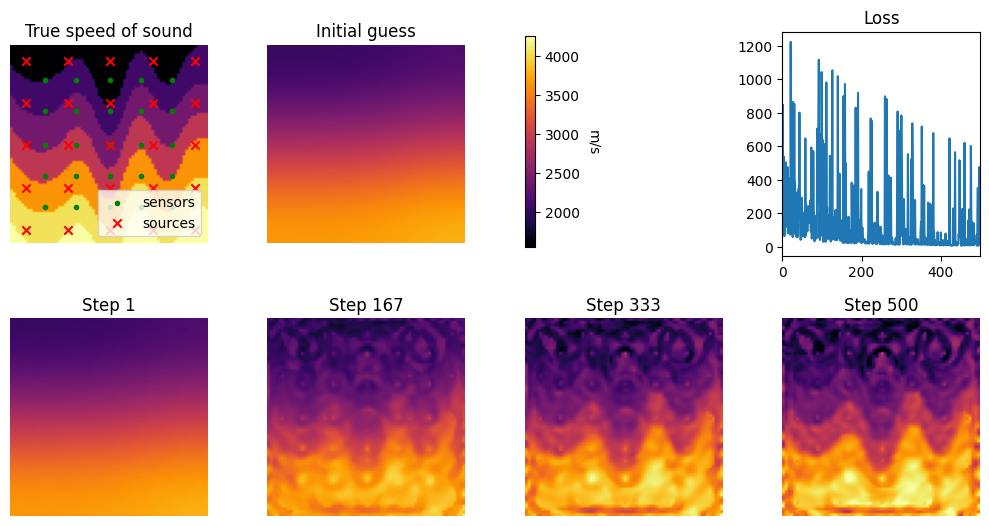

In [207]:
sos_original = get_sound_speed(params)
true_sos = true_model
vmin = np.amin(true_sos)
vmax = np.amax(true_sos)

fig, axes = plt.subplots(2, 4, figsize=(10, 5.5))

k = 0

recs = jnp.linspace(0, num_steps - 1, 4).astype(jnp.int32)

for row in range(2):
    for col in range(4):
        if k == 0:
            axes[row, col].imshow(true_sos, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].scatter(
                sensors_positions[1],
                sensors_positions[0],
                c="g",
                marker=".",
                label="sensors",
            )
            axes[row, col].scatter(
                source_positions[1],
                source_positions[0],
                c="r",
                marker="x",
                label="sources",
            )
            axes[row, col].legend(loc="lower right")
            axes[row, col].set_title("True speed of sound")
            axes[row, col].set_axis_off()
        elif k == 1:
            im_original = axes[row, col].imshow(sos_original, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Initial guess")
            
            cbar_ax = fig.add_axes([0.53, 0.54, 0.01, 0.385])
            cbar = plt.colorbar(im_original, cax=cbar_ax)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('m/s', rotation=270)
        elif k == 2:
            axes[row, col].set_axis_off()
        elif k == 3:
            axes[row, col].plot(losshistory)
            axes[row, col].set_title("Loss")
            #axes[row, col].set_xticks([], [])
            axes[row, col].margins(x=0)
        else:
            axes[row, col].imshow(reconstructions[recs[k - 4]], cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Step {}".format(recs[k - 4] + 1))
        k += 1

# Scale bar
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# import matplotlib.font_manager as fm
# fontprops = fm.FontProperties(size=12)
# scalebar = AnchoredSizeBar(
#     axes[-1, -1].transData,
#     100, '1 cm', 'lower right', 
#     pad=0.3,
#     color='white',
#     frameon=False,
#     size_vertical=2,
#     fontproperties=fontprops)
# axes[-1, -1].add_artist(scalebar)
        
fig.tight_layout()

plt.savefig('fwi.pdf')

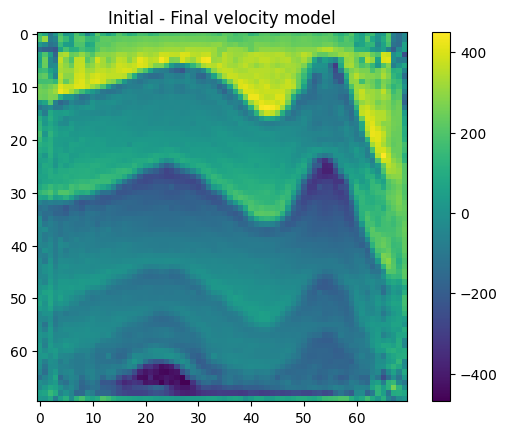

In [109]:
plt.imshow(reconstructions[0] - reconstructions[-1])
plt.colorbar()
plt.title("Initial - Final velocity model")
plt.show()